In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Camera Calibration

In [2]:
%matplotlib qt
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        
        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

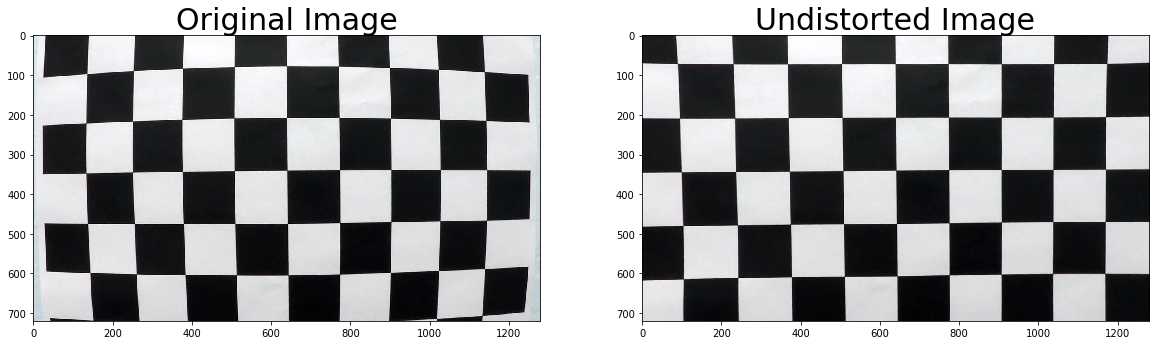

In [3]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Distortion correction of test images

In [4]:
test_images = glob.glob('test_images/*')
for image_name in test_images:
    img = cv2.imread(image_name)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/' + image_name.split('/')[-1], img)

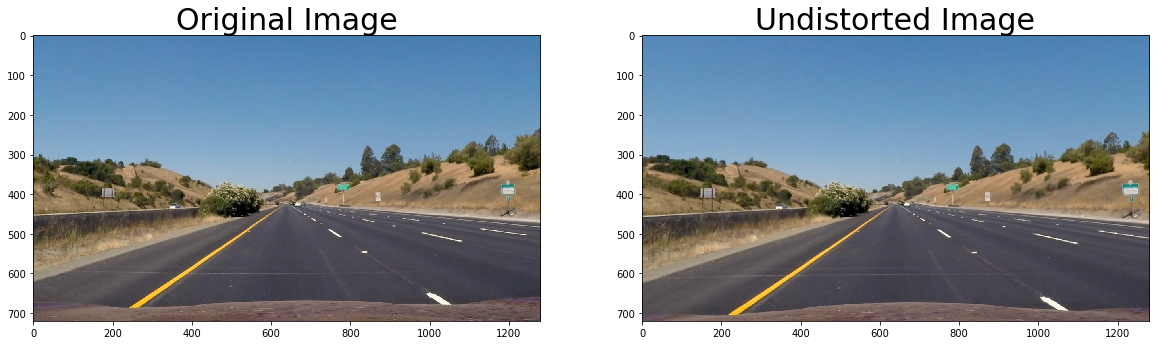

In [175]:
test_img_name = 'output_images/straight_lines1.jpg'

test_img = mpimg.imread(test_img_name)
test_origin_img = mpimg.imread('test_images/' + test_img_name.split('/')[-1])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_origin_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_img)
ax2.set_title('Undistorted Image', fontsize=30)

## Threshold

In [11]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 255

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 255

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 255

    # Return the binary image
    return binary_output


In [168]:
def get_binary_img(img):
    height = img.shape[0]
    width = img.shape[1]
    
    S = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    L = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,1]
    # 亮度的明暗变化对梯度提取会有影响    
    
    _,L_img = cv2.threshold(L,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)    
    
    grad_img = mag_thresh(S, sobel_kernel=15, thresh=(30, 200))
    
    dir_img = dir_threshold(S, sobel_kernel=21, thresh=(0.5, 1.2))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
    dir_img = cv2.erode(dir_img, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    dir_img = cv2.dilate(dir_img, kernel)
    
    threshd_img = np.zeros_like(dir_img)
    threshd_img[((dir_img==255) & (grad_img==255)) & (L_img==255)] = 1
    
    mask = np.zeros_like(threshd_img)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    threshd_img = cv2.bitwise_and(threshd_img, mask)
    
    return threshd_img

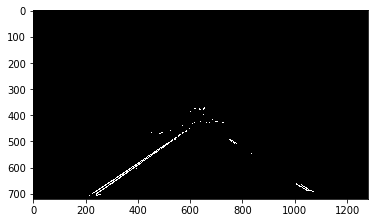

In [178]:
binary_img = get_binary_img(test_img)
plt.imshow(binary_img, cmap='gray')

## Perspective transform

In [14]:
src = np.array([[575,460], [708,460], [1110,720], [190, 720]])
dst = np.array([[200,100], [1000,100], [1000,700], [200,700]])

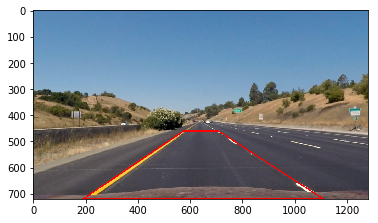

In [176]:
copy = np.copy(test_img)
copy = cv2.polylines(copy,[src],True,(255,0,0), thickness=3)

plt.imshow(copy)

In [16]:
M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
M_inv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))

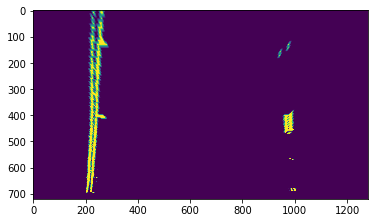

In [179]:
warped_img = cv2.warpPerspective(binary_img, M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
plt.imshow(warped_img)

## Identified lane-line

In [18]:
def calc_polifit(img, nwindows=9, margin=100, minpix=50, last_left_fit=None, last_right_fit=None):
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = img.nonzero()[0]
    nonzerox = img.nonzero()[1]
    
    # Create empty lists to receive left and right lane pixel indices
    left_x = []
    right_x = []
    left_y = []
    right_y = []
    
    
    if (last_left_fit is None) or (last_right_fit is None):
        histogram = np.sum(img, axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
            left_x.append(leftx_current)
            right_x.append(rightx_current)
            left_y.append((win_y_low+win_y_high)//2)
            right_y.append((win_y_low+win_y_high)//2)
            
    else:
        left_lane_inds = ((nonzerox > (last_left_fit[0]*(nonzeroy**2) + last_left_fit[1]*nonzeroy + 
        last_left_fit[2] - margin)) & (nonzerox < (last_left_fit[0]*(nonzeroy**2) + 
        last_left_fit[1]*nonzeroy + last_left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (last_right_fit[0]*(nonzeroy**2) + last_right_fit[1]*nonzeroy + 
        last_right_fit[2] - margin)) & (nonzerox < (last_right_fit[0]*(nonzeroy**2) + 
        last_right_fit[1]*nonzeroy + last_right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        left_x = nonzerox[left_lane_inds]
        left_y = nonzeroy[left_lane_inds] 
        right_x = nonzerox[right_lane_inds]
        right_y = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_y, left_x, 2)

    right_fit = np.polyfit(right_y, right_x, 2)
        
    return left_fit, right_fit
    

(720, 0)

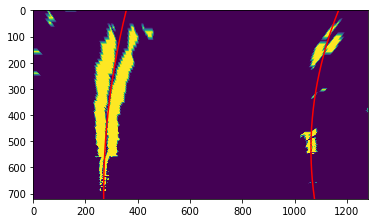

In [171]:
l,r = calc_polifit(warped_img)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = l[0]*ploty**2 + l[1]*ploty + l[2]
right_fitx = r[0]*ploty**2 + r[1]*ploty + r[2]
plt.imshow(warped_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Radius of curvature and car pos

In [20]:
radius_curv = 0
car_pos = 0
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

## Inverse 

In [21]:
def inverse_img(img, binary_warped, M_inv):    
    global radius_curv, car_pos
    
    l,r = calc_polifit(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l[0]*ploty**2 + l[1]*ploty + l[2]
    right_fitx = r[0]*ploty**2 + r[1]*ploty + r[2]
    
    radius_curv = (((1+(2*l[0]*xm_per_pix+l[1])**2)**1.5)/(np.abs(l[0])*2) + \
                    ((1+(2*r[0]*xm_per_pix+r[1])**2)**1.5)/(np.abs(r[0])*2))/2
    car_pos = (img.shape[1]/2 - (left_fitx[-1] + right_fitx[-1])/2)*xm_per_pix
    
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    left_line = np.transpose(np.vstack([left_fitx, ploty]))
    right_line = np.transpose(np.vstack([right_fitx, ploty]))
    line_points = np.vstack((left_line, right_line[::-1,:]))

    out_img = cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

    unwarped = cv2.warpPerspective(out_img, M_inv, binary_warped.shape[::-1] , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(np.uint8(img), 1, np.uint8(unwarped), 0.3, 0)
    return result
    

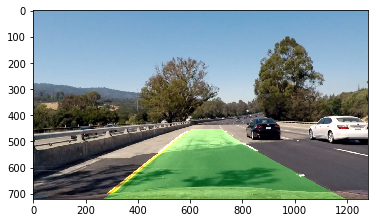

In [172]:
aa = inverse_img(test_img, warped_img, M_inv)

plt.imshow(aa)

In [23]:
radius_curv,car_pos

(132392.68805770946, -0.17744060267857273)

# Pipeline

In [24]:
def video_pipeline(img):
    global mtx, dist, M, M_inv, radius_curv, car_pos
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    threshd_img = get_binary_img(img)
    warped_img = cv2.warpPerspective(threshd_img, M, threshd_img.shape[::-1], flags=cv2.INTER_NEAREST)
        
    result = inverse_img(img, warped_img, M_inv)
    
    r_string = "Radius of curvature: %.2f m" % radius_curv
    p_string = "Center offset: %.2f m" % car_pos
    
    cv2.putText(result,r_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, p_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result
    

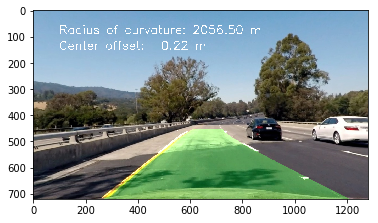

In [173]:
result = video_pipeline(test_img)

plt.imshow(result)


In [103]:
from moviepy.editor import VideoFileClip

In [174]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:41<00:00,  3.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 16min 7s, sys: 1.02 s, total: 16min 8s
Wall time: 6min 42s
